No data points for Rio de Janeiro, skipping trend line.


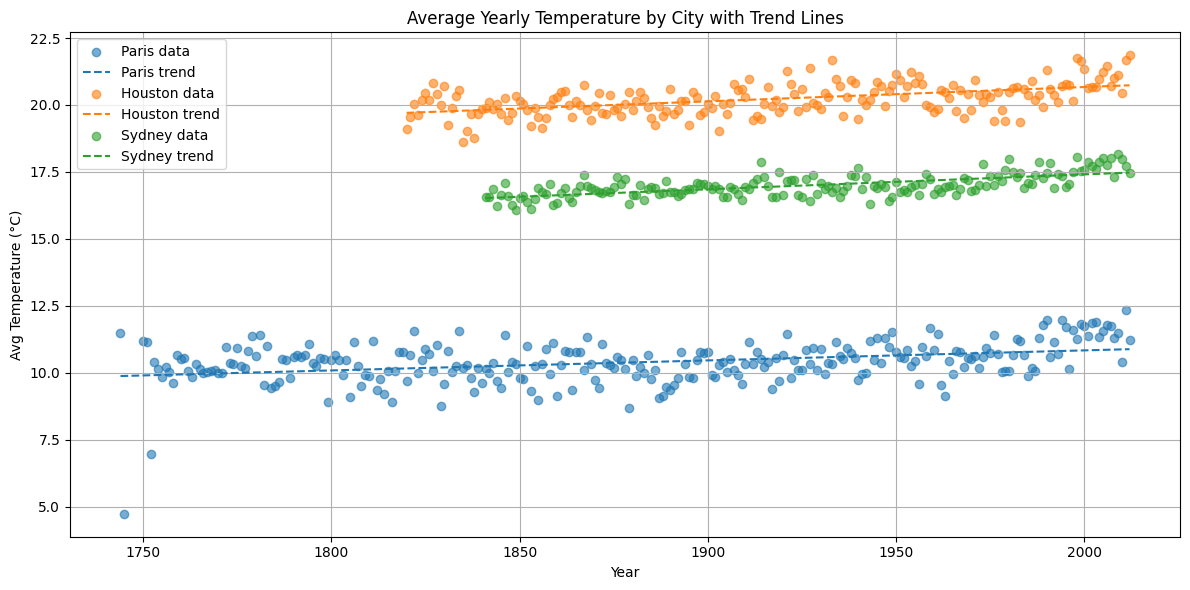

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# load the Excel data
file_path = "C:/Projects/Capstone/CO2-Emissions-and-Global-Temperature-Analysis/Data/Cleaned/Avg_Yearly_Temps.xlsx"  # Adjust if your file name differs
df = pd.read_excel(file_path)


cities = ["Paris", "Houston", "Rio de Janeiro", "Sydney"]
df = df[df["City"].isin(cities)]
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["AvgTemp"] = pd.to_numeric(df["AvgTemp"], errors="coerce")

plt.figure(figsize=(12, 6))

for city in cities:
    city_df = df[df["City"] == city].sort_values("Year")
    x = city_df["Year"].values
    y = city_df["AvgTemp"].values

    # Skip if empty
    if x.size == 0 or y.size == 0:
        print(f"No data points for {city}, skipping trend line.")
        continue

    plt.scatter(x, y, alpha=0.6, label=f"{city} data")

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "--", label=f"{city} trend")

plt.title("Average Yearly Temperature by City with Trend Lines")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#smiller